## Prepare for battle

In [92]:
import datetime
import os
import time

import keras
import matplotlib as plt
import matplotlib.pyplot as pplt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.metrics
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from keras import backend as K
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from progress.bar import IncrementalBar
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical

In [2]:
rng = np.random.default_rng()

In [3]:
def plot_grid(X, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = pplt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    imgs = X[rng.choice(np.arange(X.shape[0]), size=ax.shape)].reshape(*ax.shape, 28, 28)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [4]:
def plot_grid_and_label(X, y, model, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True, flatten_image=True, label_description=None):
    fig, ax = pplt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    idx = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs, labels = X[idx], y[idx]
    inputs = imgs.reshape(-1, *imgs.shape[2:])
    
    if flatten_image:
        inputs = inputs.reshape(nrows * ncols, -1)
        
    map_label = (lambda x: x) if label_description is None else (lambda x: label_description[x])
        
    preds = np.argmax(tf.nn.softmax(model.predict(inputs)), axis=-1).reshape(nrows, ncols)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(f'label: {map_label(labels[i, j])}, prediction: {map_label(preds[i, j])}')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [72]:
X, y = sklearn.datasets.fetch_openml('Kuzushiji-49', version=1, return_X_y=True, as_frame=False, parser='auto')
y = np.array(list(map(int, y)))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [73]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((203184, 784), (67728, 784), (203184,), (67728,))

In [6]:
label_description = [
     'A',   'I',   'U',  'E',  'O',
    'KA',  'KI',  'KU', 'KE', 'KO',
    'SA', 'SHI',  'SU', 'SE', 'SO',
    'TA', 'CHI', 'TSU', 'TE', 'TO',
    'NA',  'NI',  'NU', 'NE', 'NO',
    'HA',  'HI',  'FU', 'HE', 'HO',
    'MA',  'MI',  'MU', 'ME', 'MO',
    'YA',         'YU',       'YO',
    'RA',  'RI',  'RU', 'RE', 'RO',
    'WA',  'II',        'EE', 'WO',
     'N',  'IT'
]

In [7]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }
counts

{'A': 5209,
 'I': 5182,
 'U': 5236,
 'E': 695,
 'O': 5286,
 'KA': 5205,
 'KI': 5290,
 'KU': 5307,
 'KE': 4053,
 'KO': 5260,
 'SA': 5285,
 'SHI': 5233,
 'SU': 5244,
 'SE': 3609,
 'SO': 3335,
 'TA': 5273,
 'CHI': 2224,
 'TSU': 5210,
 'TE': 5255,
 'TO': 5205,
 'NA': 5225,
 'NI': 5310,
 'NU': 1824,
 'NE': 2132,
 'NO': 5288,
 'HA': 5286,
 'HI': 4495,
 'FU': 5281,
 'HE': 5183,
 'HO': 1755,
 'MA': 5333,
 'MI': 2655,
 'MU': 1507,
 'ME': 2938,
 'MO': 5266,
 'YA': 5275,
 'YU': 1361,
 'YO': 5234,
 'RA': 5261,
 'RI': 5219,
 'RU': 5235,
 'RE': 5275,
 'RO': 1858,
 'WA': 2068,
 'II': 371,
 'EE': 350,
 'WO': 5249,
 'N': 5267,
 'IT': 3087}

## Resolving imbalanced classes problem

In [8]:
smt = SMOTE()
X_res, y_res = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

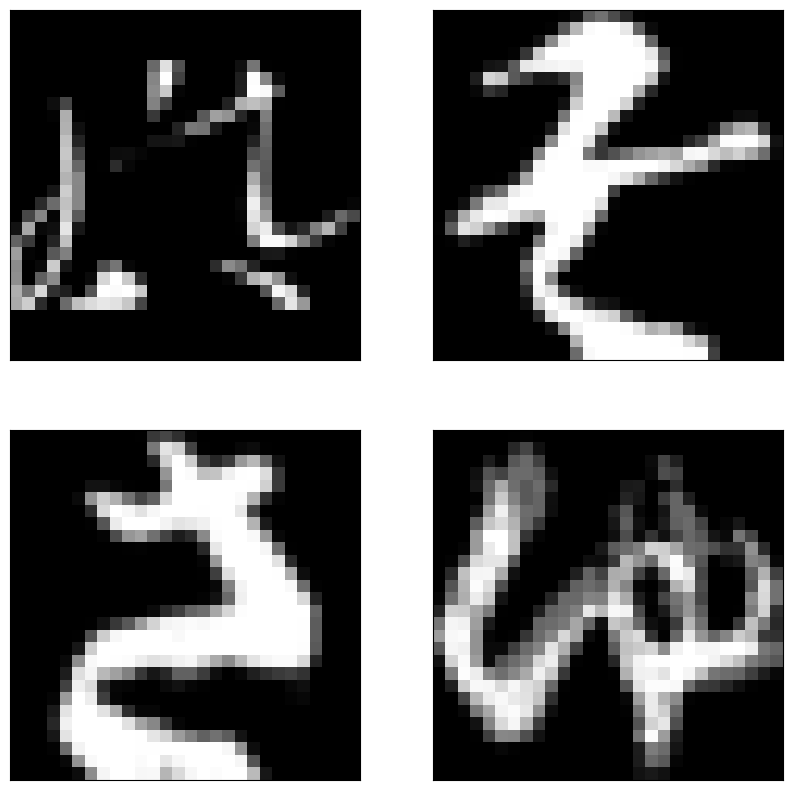

In [9]:
plot_grid(X_train)

## Flattened images

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(49, activation=tf.nn.softmax))

In [13]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train, 
          epochs=5, 
          callbacks=callbacks, 
          validation_data=(X_test, y_test))

Epoch 1/5
8025/8040 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.7292

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 18s 2ms/step - loss: 1.0366 - accuracy: 0.7293 - val_loss: 0.6726 - val_accuracy: 0.8181
Epoch 2/5
8032/8040 [============================>.] - ETA: 0s - loss: 0.5415 - accuracy: 0.8529

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.5415 - accuracy: 0.8529 - val_loss: 0.5079 - val_accuracy: 0.8610
Epoch 3/5
8033/8040 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8819

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.4268 - accuracy: 0.8819 - val_loss: 0.4414 - val_accuracy: 0.8799
Epoch 4/5
8027/8040 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8986

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.3656 - accuracy: 0.8986 - val_loss: 0.4130 - val_accuracy: 0.8880
Epoch 5/5
8035/8040 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.9089

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.3257 - accuracy: 0.9089 - val_loss: 0.3942 - val_accuracy: 0.8931


In [16]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

2680/2680 [==============================] - 2s 686us/step - loss: 0.3942 - accuracy: 0.8931
0.39422711730003357 0.8931311964988708


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 49)                6321      
                                                                 
Total params: 123,313
Trainable params: 123,313
Non-trainable params: 0
_________________________________________________________________


In [18]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

1/1 [==============================] - 0s 19ms/step


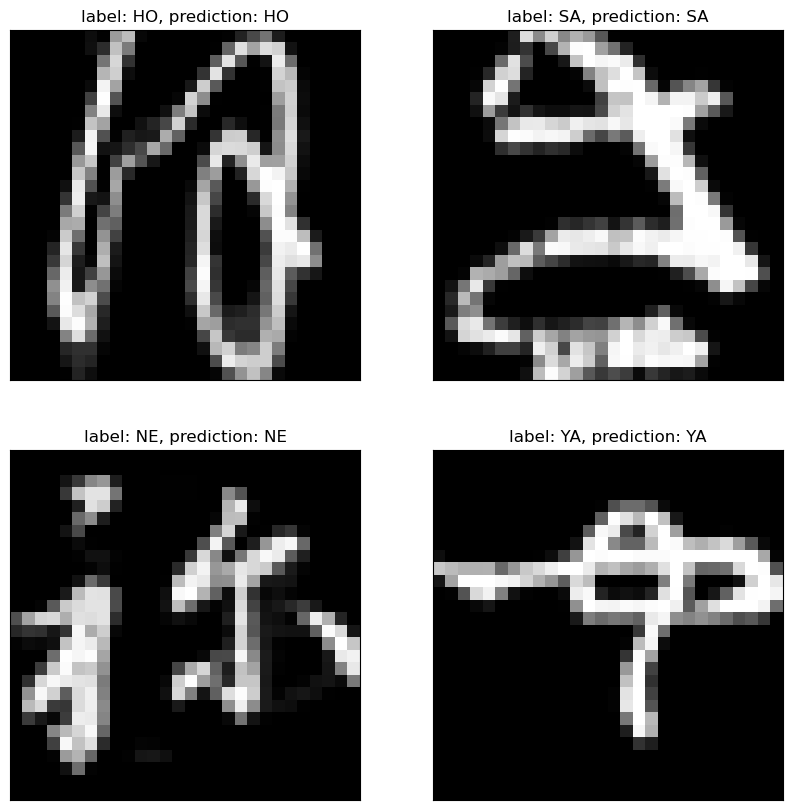

In [24]:
plot_grid_and_label(images, y_test, model, label_description=label_description)

In [29]:
y_pred = model.predict(X_test).argmax(axis=1)

2680/2680 [==============================] - 2s 668us/step


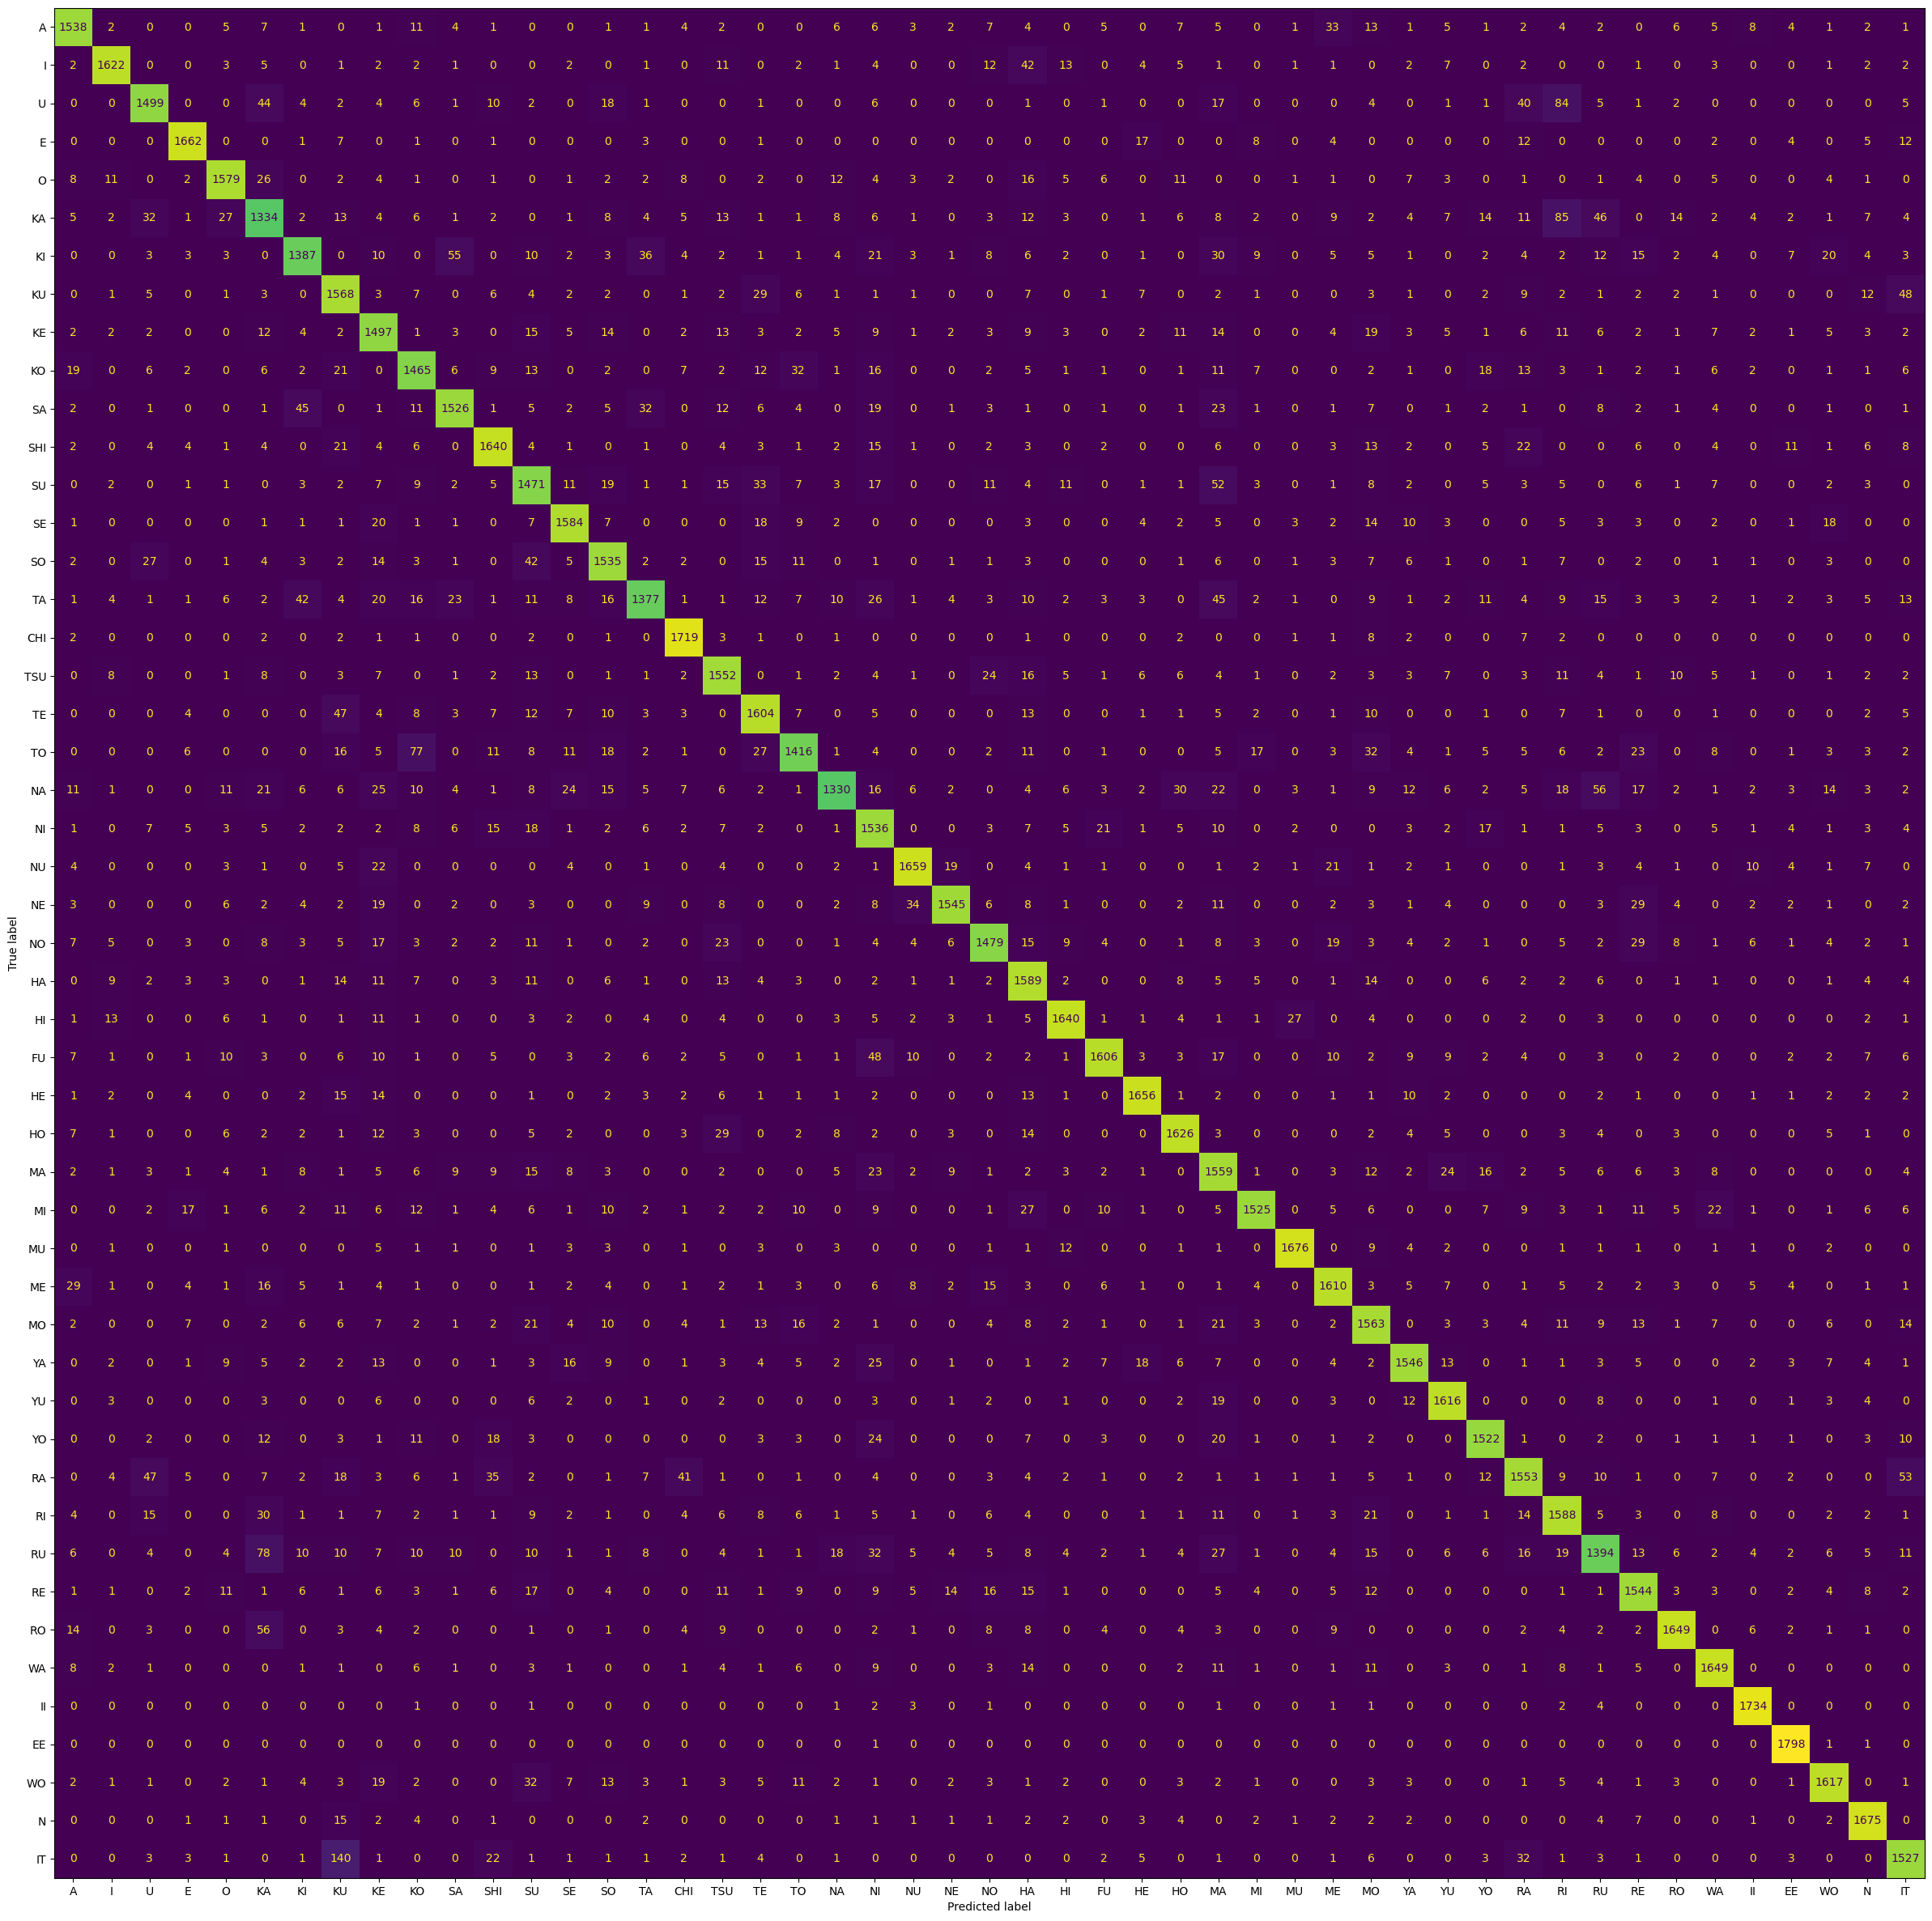

In [30]:
_, ax = pplt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [31]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.8930747448583877

## Actual images

In [109]:
keras.backend.clear_session()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255.0
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) / 255.0

In [119]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(49, activation='softmax')
])

In [120]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [121]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [122]:
model.fit(X_train, y_train, 
          epochs=5, 
          callbacks=callbacks, 
          validation_data=(X_test, y_test))

Epoch 1/5
8038/8040 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8830

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


8040/8040 [==============================] - 74s 9ms/step - loss: 0.4411 - accuracy: 0.8830 - val_loss: 0.2259 - val_accuracy: 0.9375
Epoch 2/5
8038/8040 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9515

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


8040/8040 [==============================] - 74s 9ms/step - loss: 0.1746 - accuracy: 0.9515 - val_loss: 0.1698 - val_accuracy: 0.9534
Epoch 3/5
8033/8040 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9649

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


8040/8040 [==============================] - 71s 9ms/step - loss: 0.1230 - accuracy: 0.9649 - val_loss: 0.1556 - val_accuracy: 0.9570
Epoch 4/5
8035/8040 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9724

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-121921/assets


8040/8040 [==============================] - 72s 9ms/step - loss: 0.0940 - accuracy: 0.9724 - val_loss: 0.1501 - val_accuracy: 0.9604
Epoch 5/5
8040/8040 [==============================] - 71s 9ms/step - loss: 0.0754 - accuracy: 0.9773 - val_loss: 0.1573 - val_accuracy: 0.9606


In [123]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [124]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [125]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

1/1 [==============================] - 0s 59ms/step


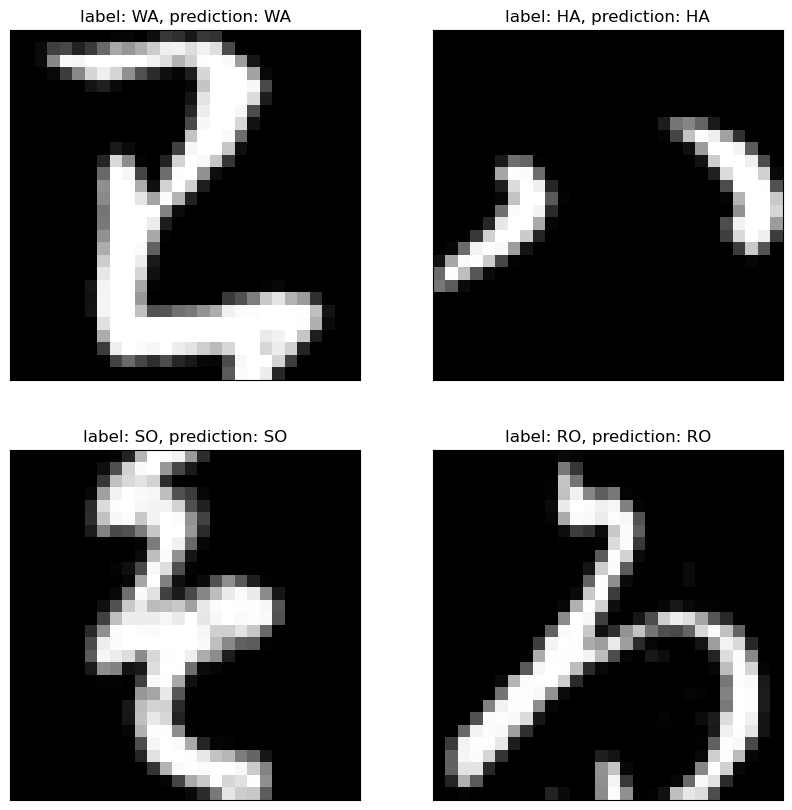

In [126]:
plot_grid_and_label(images, y_test, model, label_description=label_description, flatten_image=False)

In [127]:
y_pred = model.predict(X_test).argmax(axis=1)

2680/2680 [==============================] - 8s 3ms/step


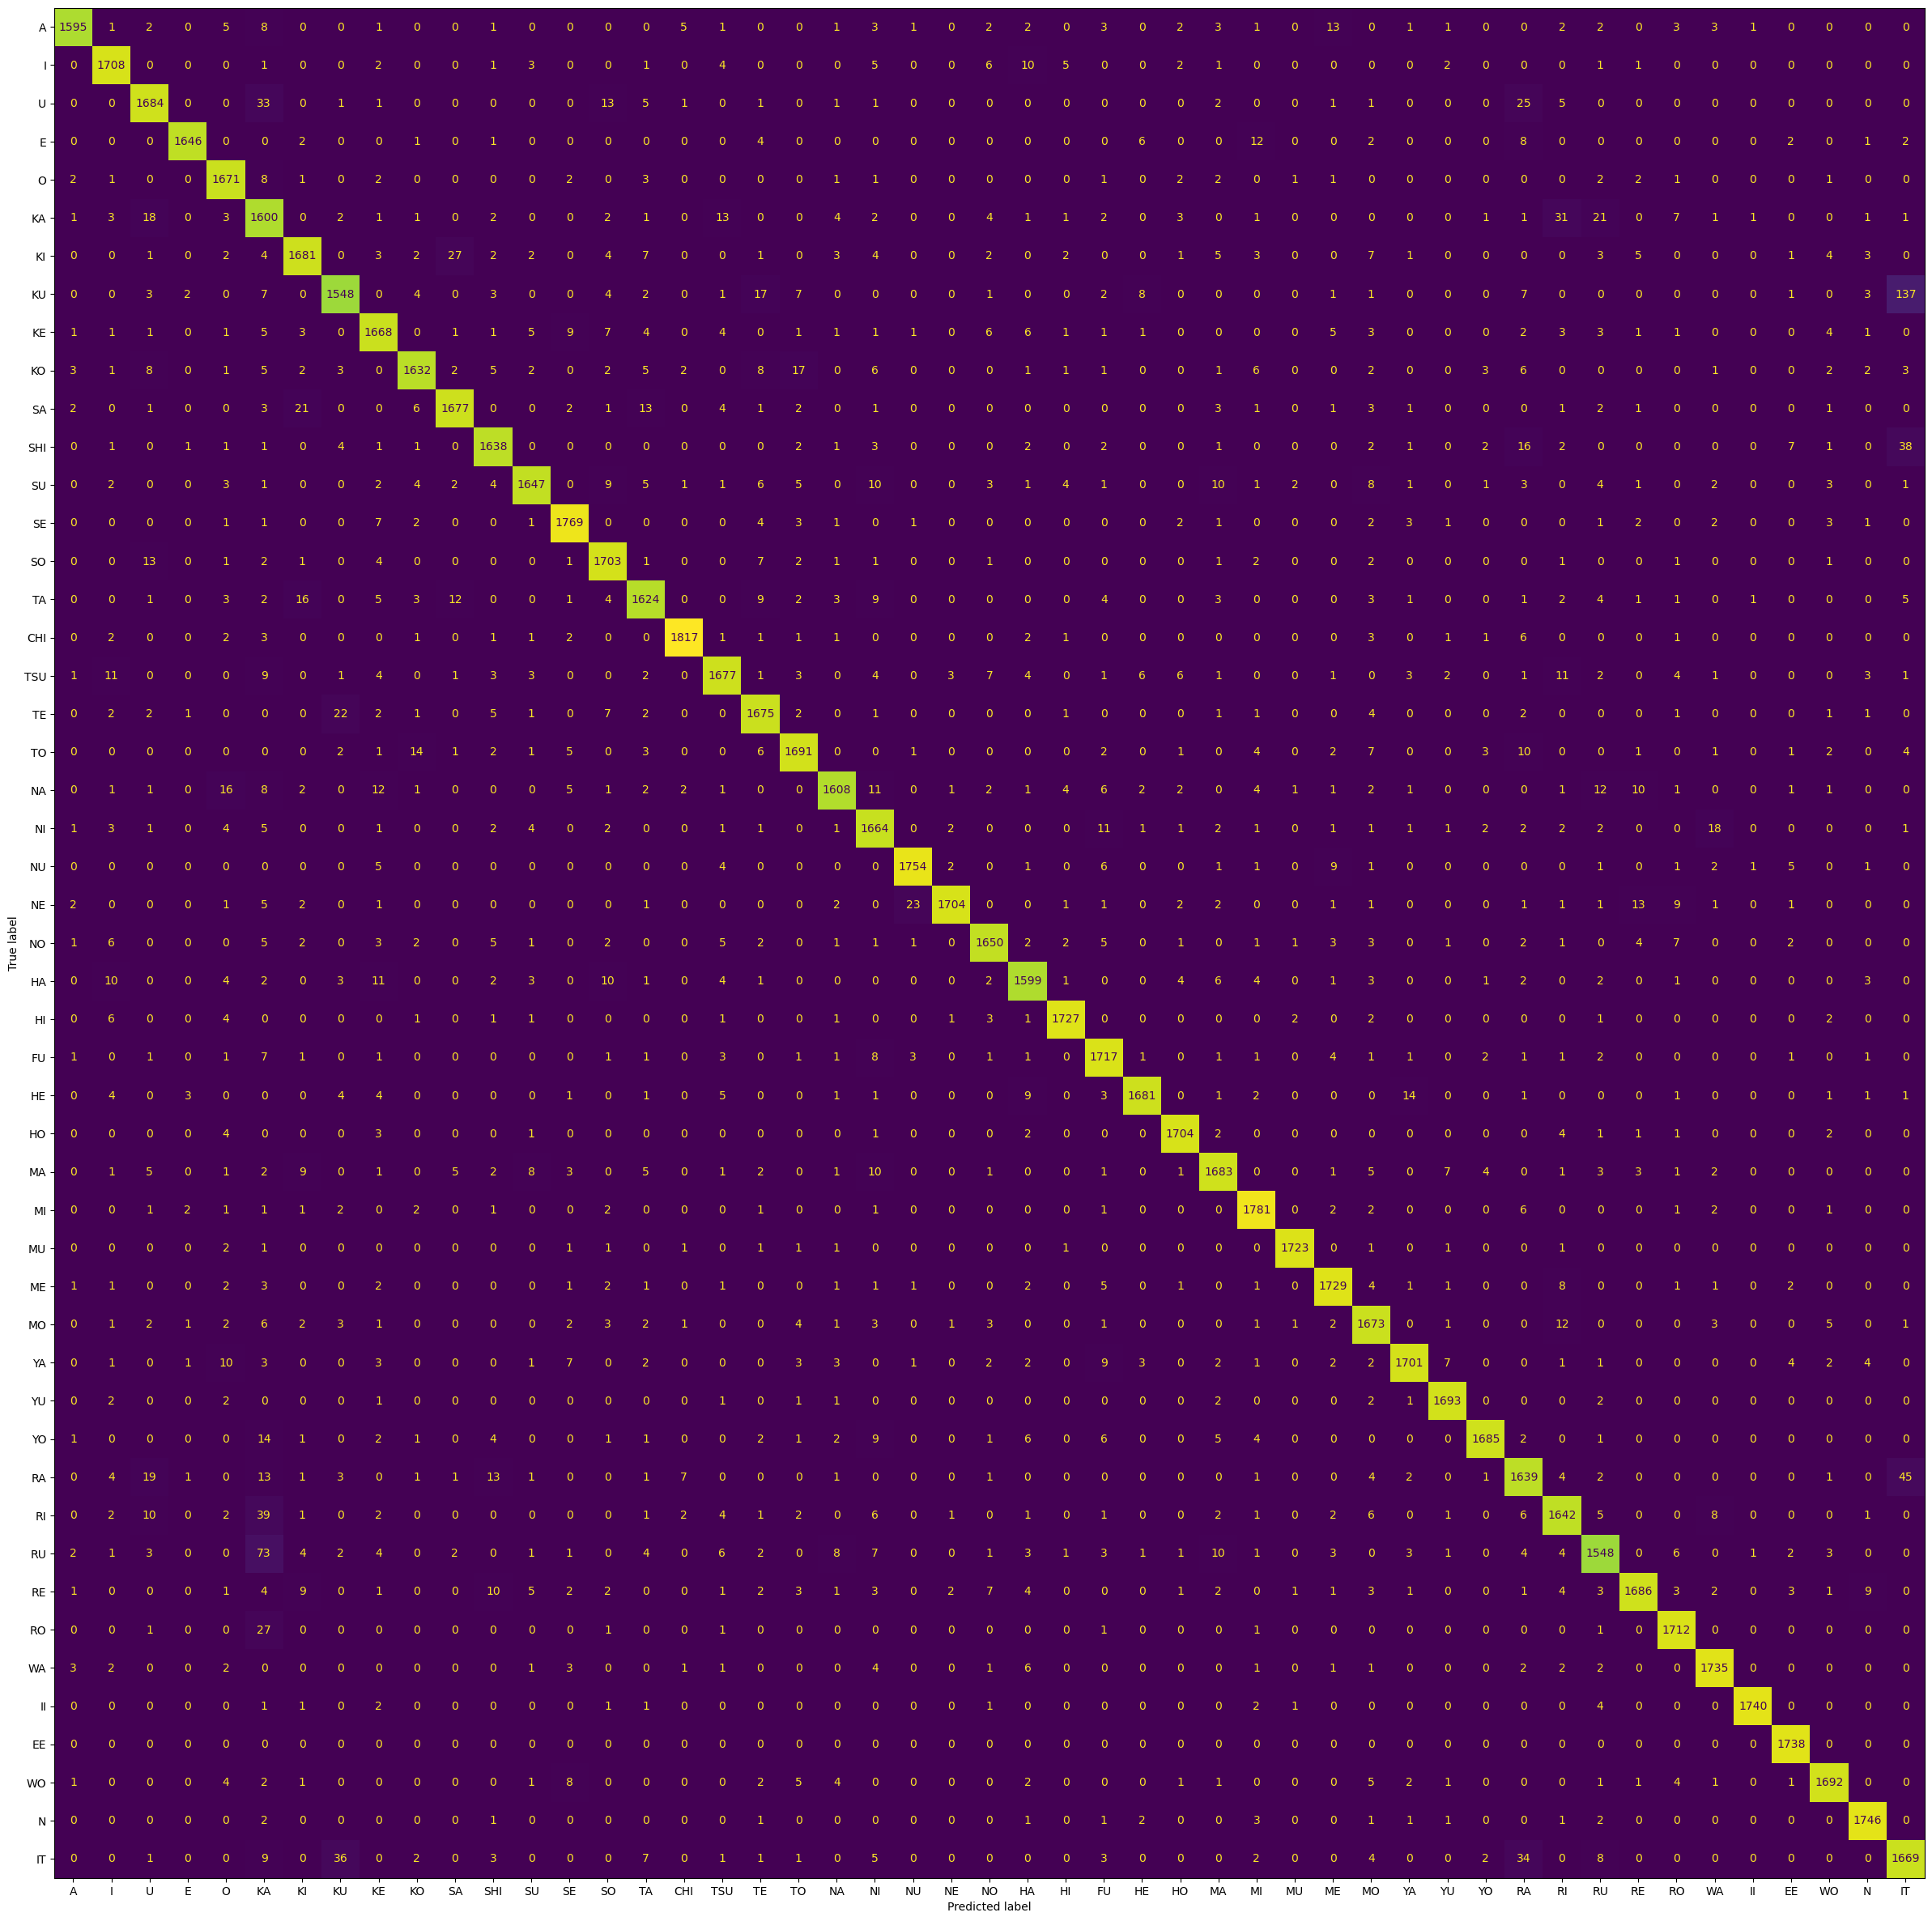

In [129]:
_, ax = pplt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [130]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.960594916236295